# Gammapy image example

A quick example how to make a significance image of the Crab nebula with Gammapy.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Data access

We will use the `DataStore` to access some example H.E.S.S. data (IRFs are real, events are simulated).

In [2]:
from gammapy.data import DataStore
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')

In [3]:
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /home/hfm/adonath/Software/Repositories/gammapy-extra/datasets/hess-crab4-hd-hap-prod2
Rows: 28
OBS_ID: 23523 -- 23592
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_king', 'psf_table']

Observation table:
Number of observations: 4


In [4]:
data_store.hdu_table[:10]

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE,MTIME,MD5
int64,str6,str10,str26,str30,str12,int64,float64,str32
23523,gti,gti,run023400-023599/run023523,hess_events_023523.fits.gz,GTI,620975,1455089616.34,9e402094c3a3e05ae4199b7cc9a01215
23523,events,events,run023400-023599/run023523,hess_events_023523.fits.gz,EVENTS,620975,1455089616.34,9e402094c3a3e05ae4199b7cc9a01215
23523,aeff,aeff_2d,run023400-023599/run023523,hess_aeff_2d_023523.fits.gz,AEFF_2D,3727,1455089616.34,6430c082176f092e0aed0f2bf9840915
23523,edisp,edisp_2d,run023400-023599/run023523,hess_edisp_2d_023523.fits.gz,EDISP_2D,28963,1455089616.34,f580ea6cb104e4d6735b8d2940ac6774
23523,psf,psf_3gauss,run023400-023599/run023523,hess_psf_3gauss_023523.fits.gz,PSF_2D_GAUSS,3027,1455089616.34,87f2d5c5ca56575a4a083b33e9700312
23523,psf,psf_king,run023400-023599/run023523,hess_psf_king_023523.fits.gz,PSF_2D_KING,1823,1455089616.34,7760e349a40883345406c7e3ea1cbd54
23523,psf,psf_table,run023400-023599/run023523,hess_psf_table_023523.fits.gz,PSF_2D_TABLE,221574,1455089616.35,74b745938341d0f64b79f60da7f1ad0f
23526,gti,gti,run023400-023599/run023526,hess_events_023526.fits.gz,GTI,618586,1455089616.56,30bfa2ac56f64471afb8768b11e9a26e
23526,events,events,run023400-023599/run023526,hess_events_023526.fits.gz,EVENTS,618586,1455089616.56,30bfa2ac56f64471afb8768b11e9a26e


## Counts image

Let's make a counts image using the `SkyMap` class.

In [5]:
from astropy.coordinates import SkyCoord
source_pos = SkyCoord(83.633083, 22.0145, unit='deg')
# If you have internet access, you could also use this to define the `source_pos`:
# source_pos = SkyCoord.from_name('crab')
print(source_pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>


In [6]:
from gammapy.image import SkyMap
ref_image = SkyMap.empty(nxpix=400, nypix=400, binsz=0.02,
                         xref=source_pos.ra.deg, yref=source_pos.dec.deg,
                         coordsys='CEL', proj='TAN')

In [7]:
# Make a counts image for a single observation
events = data_store.obs(obs_id=23523).events
counts_image = ref_image.copy()
counts_image.fill(events)

/home/hfm/adonath/.local/lib/python2.7/site-packages/APLpy-2.0.dev828-py2.7.egg/aplpy/labels.py:432: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self.coord == x or self.axis.apl_tick_positions_world[ipos] > 0:
INFO:astropy:Auto-setting vmin to  0.000e+00
INFO:astropy:Auto-setting vmax to  1.000e+00


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.000e+00 [aplpy.core]


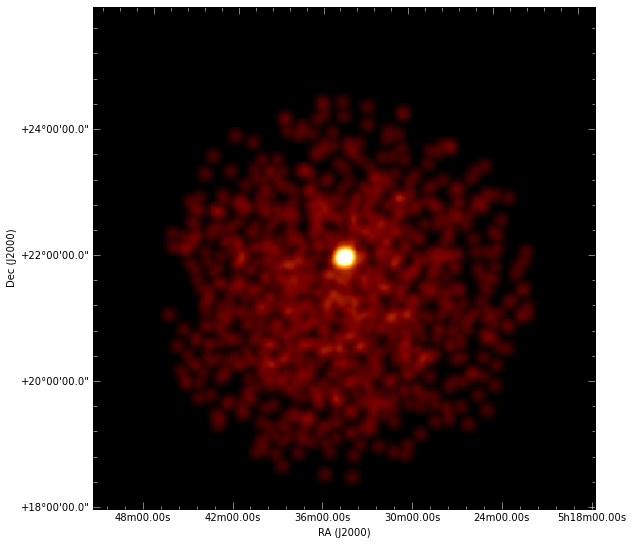

In [8]:
# This is one way to plot a sky image
from aplpy import FITSFigure
fig = FITSFigure(counts_image.to_image_hdu())
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')

In [9]:
# Making a counts image for multiple observations is a bit inconvenient at the moment
# we'll make that better soon.
# For now, you can do it like this:
obs_ids = [23523, 23526]
counts_image2 = ref_image.copy()
for obs_id in obs_ids:
    events = data_store.obs(obs_id=obs_id).events
    temp_image = ref_image.copy()
    temp_image.fill(events)
    counts_image2.data += temp_image.data

INFO:astropy:Auto-setting vmin to  0.000e+00
INFO:astropy:Auto-setting vmax to  1.000e+00


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.000e+00 [aplpy.core]


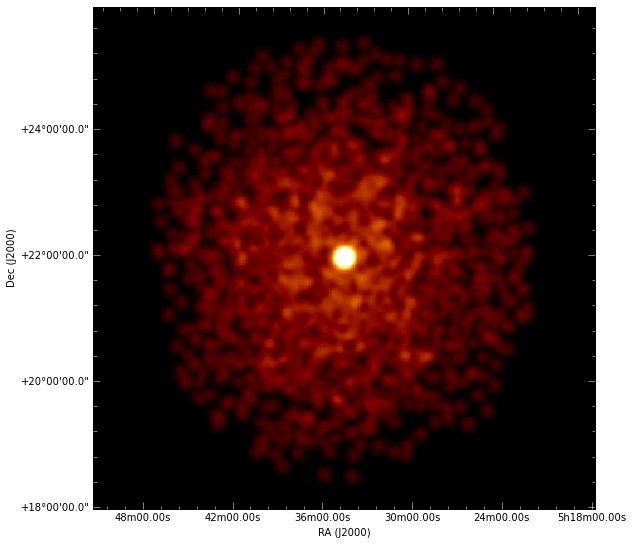

In [10]:
# Let's have a look
fig = FITSFigure(counts_image2.to_image_hdu())
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')

# Background modeling

In Gammapy a few different methods to estimate the background are available.

Here we'll use the `IterativeKernelBackgroundEstimator` to make a background image
and the make a significance image.

In [11]:
# To use the `IterativeKernelBackgroundEstimator` you first have to set
# up a source and background kernel and put the counts image input
# into a container `GammaImages` class
from gammapy.image import binary_disk, binary_ring
from gammapy.background import IterativeKernelBackgroundEstimator as IKBE
from gammapy.background import GammaImages
images = GammaImages(counts_image2.data, header=counts_image2.wcs.to_header())
source_kernel = binary_disk(5)
background_kernel = binary_ring(20, 30)

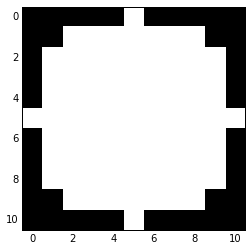

In [12]:
plt.imshow(source_kernel, interpolation='nearest', cmap='gray')

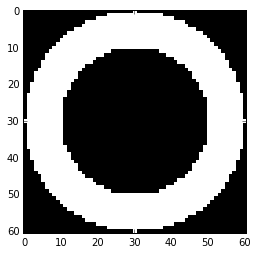

In [13]:
plt.imshow(background_kernel, interpolation='nearest', cmap='gray')

In [14]:
ikbe = IKBE(
    images=images,
    source_kernel=source_kernel,
    background_kernel=background_kernel,
    significance_threshold=5,
    mask_dilation_radius=3,
)
# This takes about 10 seconds on my machine
result = ikbe.run()

/home/hfm/adonath/Software/Repositories/gammapy/gammapy/stats/poisson.py:254: RuntimeWarning: invalid value encountered in sqrt
  term_b = sqrt(n_observed * log(n_observed / mu_background) - n_observed + mu_background)


INFO:astropy:Auto-setting vmin to  0.000e+00
INFO:astropy:Auto-setting vmax to  1.038e-01
/home/hfm/adonath/.local/lib/python2.7/site-packages/matplotlib-1.5.x-py2.7-linux-x86_64.egg/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.038e-01 [aplpy.core]


/home/hfm/adonath/.local/lib/python2.7/site-packages/matplotlib-1.5.x-py2.7-linux-x86_64.egg/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


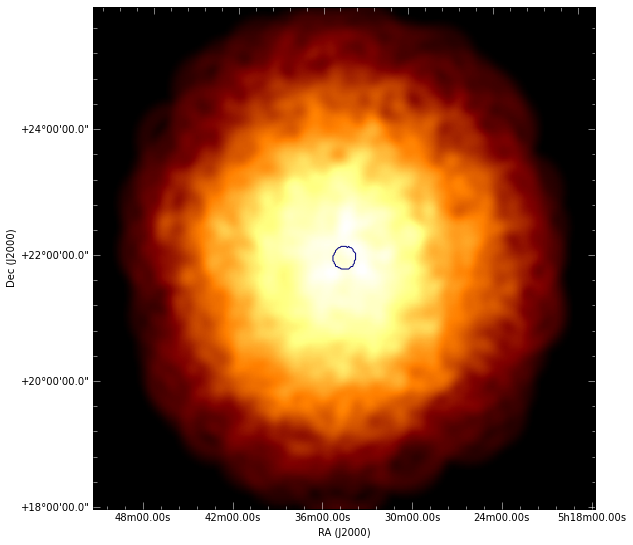

In [15]:
# Let's have a look at the background image and the exclusion mask
fig = FITSFigure(ikbe.background_image_hdu)
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')
fig.show_contour(ikbe.mask_image_hdu, levels=[0.5])

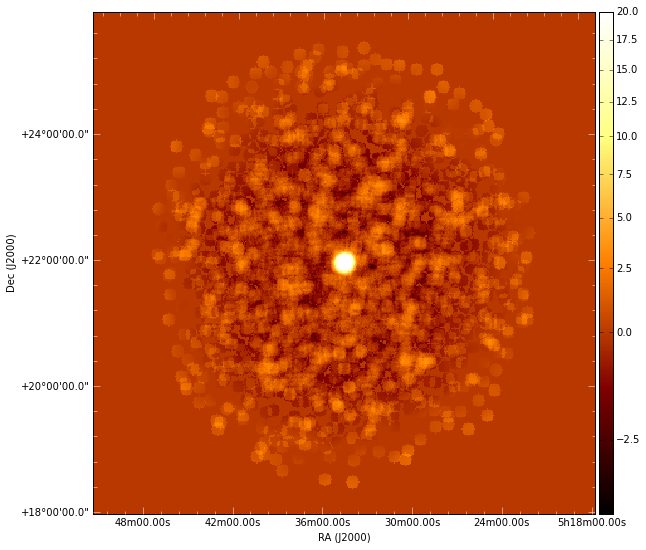

In [16]:
# Finally ... tada ... the Crab on a significance image!
fig = FITSFigure(ikbe.significance_image_hdu)
fig.show_colorscale(vmin=-3, vmax=20, stretch='sqrt', cmap='afmhot')
fig.show_colorbar()

In [17]:
print('The end!')

The end!
